In [1]:
# importing the libraries
import os
import sys
import pandas as pd
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import  glob
import time
import albumentations
import math
import shutil
import pickle
from PIL import Image
from tqdm import tqdm
from collections import Counter
from scipy.special import softmax
from sklearn.preprocessing import OneHotEncoder# creating instance of one-hot-encoder
from sklearn.model_selection import train_test_split

from models.ResNext50 import Myresnext50
from train.train_classification import trainer_classification
from utils.utils import configure_optimizers
from Datasets.DataLoader import Img_DataLoader

### PyTorch Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils import data
from torchvision import transforms
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask


In [2]:
# Load the data, split it into training and validation dataframes
df = pd.read_pickle('croppedimagepaths.pkl')

train_df, val_df = train_test_split(df, test_size=0.20, random_state=42, stratify=df['Label'])
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42, stratify=val_df['Label'])
print(f"Original set shape: {df.shape}          Training set label count: {str(Counter(df['Label'].to_list()))[7:][1:][:-1]} \n")
print(f"Training set shape: {train_df.shape}          Training set label count: {str(Counter(train_df['Label'].to_list()))[7:][1:][:-1]} \n")
print(f"Validation set shape: {val_df.shape}         Validation set label count: {str(Counter(val_df['Label'].to_list()))[7:][1:][:-1]} \n")
print(f"Test set shape: {test_df.shape}         Validation set label count: {str(Counter(test_df['Label'].to_list()))[7:][1:][:-1]} \n")

Original set shape: (20594, 4)          Training set label count: {'Other': 11821, 'Myeloid': 7576, 'Lymphoid': 1197} 

Training set shape: (16475, 4)          Training set label count: {'Other': 9457, 'Myeloid': 6061, 'Lymphoid': 957} 

Validation set shape: (2059, 4)         Validation set label count: {'Other': 1182, 'Myeloid': 757, 'Lymphoid': 120} 

Test set shape: (2060, 4)         Validation set label count: {'Other': 1182, 'Myeloid': 758, 'Lymphoid': 120} 



In [3]:
# Load filepaths, random state ensures testset is the same as in Training.ipynb
X_all = df['Filepath'].to_list()
X_train = train_df['Filepath'].to_list()
X_val = val_df['Filepath'].to_list()
X_test = test_df['Filepath'].to_list()

# Load labels
all_labels = df['Label'].to_list()
train_labels = train_df['Label'].to_list()
validation_labels = val_df['Label'].to_list()
test_labels = test_df['Label'].to_list()

# Load df that represents the one hot encoding of each cell type (Myeloid, Lymphoid, other)
cell_types_df = pd.read_pickle("cell_types_df.pkl")

In [4]:
# Load model
resnext50_pretrained = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=True)
my_extended_model = Myresnext50(my_pretrained_model= resnext50_pretrained, num_classes = 3)

Using cache found in C:\Users\moone/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\moone\miniconda3\envs\thesis\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\moone\miniconda3\envs\thesis\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Find and remove duplicates using Euclidian Distance

In [9]:
# from PIL import Image
# import numpy as np
# from tqdm import tqdm

# # Set target image size for resizing (optional but needed for fair comparison)
# resize_shape = (256, 256)

# # Load and preprocess images
# def load_image(path, size=resize_shape):
#     try:
#         with Image.open(path) as img:
#             img = img.convert("RGB")  # Ensure 3 channels
#             img = img.resize(size)
#             return np.asarray(img).astype(np.float32).flatten()
#     except Exception as e:
#         print(f"Error loading {path}: {e}")
#         return None


# # Precompute all image vectors
# images1 = [(path, load_image(path)) for path in tqdm(X_all, desc="Loading List 1")]
# # images2 = [(path, load_image(path)) for path in tqdm(X_val, desc="Loading List 2")]
# # images3 = [(path, load_image(path)) for path in tqdm(X_test, desc="Loading List 3")]

# # Compare with Euclidean distance
# matches = []
# threshold = 0.05  # Change this if you want fuzzy matching



# def find_matches_EUCD(images1, images2):
#     for path1, img1 in images1:
#         if img1 is None:
#             continue
#         for path2, img2 in images2:
#             if img2 is None or path1 == path2:
#                 continue
#             dist = np.linalg.norm(img1 - img2)
#             if dist <= threshold:
#                 matches.append((path1, path2, dist))
#     return matches


# matches1 = find_matches_EUCD(images1, images1)
# # matches2 = find_matches_EUCD(images2, images2)
# # matches3 = find_matches_EUCD(images3, images3)
# # matches4 = find_matches_EUCD(images1, images2)
# # matches5 = find_matches_EUCD(images1, images3)
# # matches6 = find_matches_EUCD(images2, images3)

In [ ]:
# import torch
# from torchvision import transforms
# import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Resize and normalize the image
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),  # Converts to [0,1] and puts channels first
])

def load_image_tensor(path):
    try:
        img = Image.open(path).convert("RGB")
        img_tensor = transform(img).to(device)
        return img_tensor.flatten()
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return None

# Load images into a single stacked tensor
def load_images_tensor(paths):
    tensors = []
    valid_paths = []
    for path in tqdm(paths, desc="Loading images"):
        tensor = load_image_tensor(path)
        if tensor is not None:
            tensors.append(tensor)
            valid_paths.append(path)
    return valid_paths, torch.stack(tensors)

valid_paths1, image_tensors1 = load_images_tensor(X_all)

# Compute pairwise distances on GPU
def find_matches_euclidean(tensors, paths, threshold=0.05):
    matches = []
    num = tensors.size(0)
    for i in tqdm(range(num), desc="Comparing images"):
        dists = torch.norm(tensors[i] - tensors, dim=1)
        print(f'At step: {i}')
        for j in range(num):
            if i != j and dists[j] <= threshold:
                matches.append((paths[i], paths[j], dists[j].item()))
    return matches

matches = find_matches_euclidean(image_tensors1, valid_paths1)


Loading images:   1%|▎                                                             | 112/20594 [00:04<23:12, 14.71it/s]

In [10]:
import torch
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

def load_image_tensor(path):
    try:
        img = Image.open(path).convert("RGB")
        img_tensor = transform(img).to(device)
        return img_tensor.flatten()
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return None

# Load image tensors on CPU first
def load_images_tensor(paths):
    tensors = []
    valid_paths = []
    for path in tqdm(paths, desc="Loading images"):
        tensor = load_image_tensor(path)
        if tensor is not None:
            tensors.append(tensor.cpu())  # Keep on CPU for now
            valid_paths.append(path)
    return valid_paths, tensors

valid_paths1, image_tensors1 = load_images_tensor(X_all)

# Chunked GPU-based matching
def find_matches_euclidean_chunked(tensors, paths, threshold=0.05, chunk_size=200):
    matches = []
    num = len(tensors)
    for start_i in tqdm(range(0, num, chunk_size), desc="Outer loop (i)"):
        end_i = min(start_i + chunk_size, num)
        batch_i = torch.stack(tensors[start_i:end_i]).to(device)

        for start_j in range(0, num, chunk_size):
            end_j = min(start_j + chunk_size, num)
            batch_j = torch.stack(tensors[start_j:end_j]).to(device)

            dists = torch.cdist(batch_i, batch_j)  # Efficient pairwise distance

            for i in range(end_i - start_i):
                for j in range(end_j - start_j):
                    # Avoid self-comparison
                    global_i, global_j = start_i + i, start_j + j
                    if global_i == global_j:
                        continue
                    dist = dists[i, j].item()
                    if dist <= threshold:
                        matches.append((paths[global_i], paths[global_j], dist))

            del batch_j, dists  # Free memory
            torch.cuda.empty_cache()

        del batch_i
        torch.cuda.empty_cache()

    return matches

matches = find_matches_euclidean_chunked(image_tensors1, valid_paths1, threshold=1, chunk_size=500)

# Save
with open("matches.pkl", "wb") as f:
    pickle.dump(matches, f)

Outer loop (i): 100%|███████████████████████████████████████████████████████████████| 42/42 [5:02:39<00:00, 432.36s/it]


In [41]:
print(len(matches))
matches

298


[('D:\\Mathijs\\Open Universiteit\\Thesis\\Implementation\\DeepHeme_training\\Datasets\\notextimages\\AML___220630002676_1_MO_51.jpg',
  'D:\\Mathijs\\Open Universiteit\\Thesis\\Implementation\\DeepHeme_training\\Datasets\\notextimages\\AML___220630002676_1_BL_37.jpg',
  0.46770718693733215),
 ('D:\\Mathijs\\Open Universiteit\\Thesis\\Implementation\\DeepHeme_training\\Datasets\\notextimages\\AML___220930003322_1_BL_189.jpg',
  'D:\\Mathijs\\Open Universiteit\\Thesis\\Implementation\\DeepHeme_training\\Datasets\\notextimages\\AML___220930003322_1_BL_190.jpg',
  0.3952847123146057),
 ('D:\\Mathijs\\Open Universiteit\\Thesis\\Implementation\\DeepHeme_training\\Datasets\\notextimages\\AML___220607003832_1_BL_158.jpg',
  'D:\\Mathijs\\Open Universiteit\\Thesis\\Implementation\\DeepHeme_training\\Datasets\\notextimages\\AML___220607003832_1_PMY_6.jpg',
  0.55901700258255),
 ('D:\\Mathijs\\Open Universiteit\\Thesis\\Implementation\\DeepHeme_training\\Datasets\\notextimages\\AML___22071200236

In [33]:
duplicatesEUCD1 = []
for match in matches:
    for i in range(len(match[:-1])):
        # if i == 0:
        #     continue
        # else:
        duplicatesEUCD1.append(match[:-1][i])
len(list(set(duplicatesEUCD1)))

212

In [42]:
import os
import shutil
from collections import defaultdict

# All matches currently are always pairwise, but we want to know if there are cases where we have a pair AB, and BC, such that we can deduce that A and C are also duplicates

# --- STEP 1: Build graph from matches ---
graph = defaultdict(set)
for img1, img2, dist in matches:
    graph[img1].add(img2)
    graph[img2].add(img1)

# --- STEP 2: Find connected components (DFS) ---
def find_connected_components(graph):
    visited = set()
    components = []

    for node in graph:
        if node not in visited:
            stack = [node]
            component = set()
            while stack:
                current = stack.pop()
                if current not in visited:
                    visited.add(current)
                    component.add(current)
                    stack.extend(graph[current] - visited)
            components.append(component)
    return components

clusters = find_connected_components(graph)

# --- STEP 3: Copy images into 'matches/cluster_XXX' directories ---
output_base = "matches"
matched_images_dir = os.path.join(output_base, "matched_images")
os.makedirs(matched_images_dir, exist_ok=True)

duplicatesEUCD1 = []

for idx, cluster in enumerate(clusters):
    cluster_dir = os.path.join(matched_images_dir, f"cluster_{idx:03d}")
    os.makedirs(cluster_dir, exist_ok=True)
    count = 0
    
    for image_path in cluster:
        filename = os.path.basename(image_path)
        dst_path = os.path.join(cluster_dir, filename)

        # For each cluster, add all but one image to a list such that these can be removed
        if count > 0:
            duplicatesEUCD1.append(f"D:\\Mathijs\\Open Universiteit\\Thesis\\Implementation\\DeepHeme_training\\Datasets\\notextimages\\{filename}")
        count+=1
        try:
            shutil.copy(image_path, dst_path)
        except Exception as e:
            print(f"Failed to copy {image_path}: {e}")


In [44]:
# Save all the duplicates per cluster as described in the cell above for access later
with open("duplicatesEUCD1.pkl", "wb") as f:
    pickle.dump(duplicatesEUCD1, f)

# Nearest neighbour algorithm applied to final layer to find duplicates

In [5]:
import torch
from tqdm import tqdm

# Extract the part of the model that leads up to (and including) the embedding layer
def extract_features(model, x):
    model.eval()
    with torch.no_grad():
        x = model.pretrained(x)  # Output is [batch_size, 1000]
    return x 


def extract_embeddings(model, dataloader, device):
    model.eval()
    embeddings = []
    labels = []
    image_paths = []  # Keep track of image file paths or indices

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            inputs = batch['image']  # (input_images, labels)
            targets = batch['label']
            inputs = inputs.to(device)
            
            # Extract feature from the penultimate layer
            features = extract_features(model, inputs.to(device))
            embeddings.append(features.cpu())
            labels.append(targets.cpu())

            if len(batch) == 3:  # optional: file paths
                image_paths.extend(batch['ID'])
    
    embeddings = torch.cat(embeddings).numpy()
    labels = torch.cat(labels).numpy()
    return embeddings, labels, image_paths

In [6]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

def find_nearest_neighbors(embeddings, n_neighbors=5, metric='cosine'):
    embeddings = normalize(embeddings)  # Normalize for cosine similarity
    nn = NearestNeighbors(n_neighbors=n_neighbors + 1, metric=metric)  # +1 for self
    nn.fit(embeddings)
    distances, indices = nn.kneighbors(embeddings)
    return distances[:, 1:], indices[:, 1:]  # exclude self

In [7]:
def get_potential_duplicates(indices, distances, labels, image_paths=None, threshold=0.05):
    potential_duplicates = []

    for i, (neigh_idxs, neigh_dists) in enumerate(zip(indices, distances)):
        for j, dist in zip(neigh_idxs, neigh_dists):
            if dist < threshold:
                same_label = labels[i] == labels[j]
                info = {
                    'source_index': i,
                    'neighbor_index': j,
                    'distance': dist,
                    'same_label': same_label
                }
                if image_paths:
                    info.update({
                        'source_image': image_paths[i],
                        'neighbor_image': image_paths[j]
                    })
                potential_duplicates.append(info)
    
    return potential_duplicates

In [8]:
def show_duplicate_pair(image_dataset, idx1, idx2):
    img1 = image_dataset[idx1]
    img2 = image_dataset[idx2]

    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img1.permute(1, 2, 0))  # CHW → HWC
    ax[0].set_title(f"Index {idx1}")
    ax[1].imshow(img2.permute(1, 2, 0))
    ax[1].set_title(f"Index {idx2}")
    plt.show()

In [9]:
def show_duplicate_pair(image_dataset, idx1, idx2):
    # image_dataset[idx] gives a file path
    img1_path = image_dataset[idx1]
    img2_path = image_dataset[idx2]

    img1 = Image.open(img1_path)
    img2 = Image.open(img2_path)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img1)
    ax[0].set_title(f"Index {idx1}")
    ax[0].axis('off')

    ax[1].imshow(img2)
    ax[1].set_title(f"Index {idx2}")
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()


In [10]:
#Define transform pipeline, model, dataloader, and device
transform_pipeline = albumentations.Compose(
    [
        albumentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        
    ]
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnext50_pretrained = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d')
My_model = Myresnext50(my_pretrained_model= resnext50_pretrained, num_classes = 3).cuda().eval()
images = Img_DataLoader(img_list=X_all, labels=all_labels, split='viz',df=cell_types_df, transform=transform_pipeline)
shuffle = False
dataloader = DataLoader(images, batch_size=32, num_workers=8, shuffle=shuffle)

Using cache found in C:\Users\moone/.cache\torch\hub\pytorch_vision_v0.10.0


In [11]:
embeddings, labels, image_paths = extract_embeddings(My_model, dataloader, device)

In [12]:
distances, indices = find_nearest_neighbors(embeddings, n_neighbors=5, metric='cosine')

In [13]:
potential_duplicates = get_potential_duplicates(indices, distances, labels, image_paths=image_paths, threshold=0.000049)
len(potential_duplicates)

2105

In [ ]:
for i in range(5):  # Display 5 pairs
    pair = potential_duplicates[i]
    idx1 = pair['source_index']
    idx2 = pair['neighbor_index']
    print(f"Pair {i}: Distance = {pair['distance']:.8f}, Same label = {pair['same_label']}")
    show_duplicate_pair(X_all, idx1, idx2)

In [110]:
# # Code to adjust threshold specifically for lymphoid images, to definitively conclude that there are no more duplicate images among lymphoid blasts

# df = pd.read_pickle('notextimagepaths.pkl')
# X_lymphoid = df[df['Label'] == 'Lymphoid']['Filepath'].to_list()
# lymphoid_labels = df[df['Label'] == 'Lymphoid']['Label'].to_list()

# #Define transform pipeline, model, dataloader, and device
# transform_pipeline = albumentations.Compose(
#     [
#         albumentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        
#     ]
# )

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# resnext50_pretrained = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d')
# My_model = Myresnext50(my_pretrained_model= resnext50_pretrained, num_classes = 3).cuda().eval()
# images = Img_DataLoader(img_list=X_lymphoid, labels=lymphoid_labels, split='viz',df=cell_types_df, transform=transform_pipeline)
# shuffle = False
# dataloader = DataLoader(images, batch_size=32, num_workers=8, shuffle=shuffle)

# embeddings, labels, image_paths = extract_embeddings(My_model, dataloader, device)

# distances, indices = find_nearest_neighbors(embeddings, n_neighbors=5, metric='cosine')

# potential_duplicates = get_potential_duplicates(indices, distances, labels, image_paths=image_paths, threshold=0.00008)
# print(f"Found duplicate pairs: {len(potential_duplicates)}")

# for i in range(len(potential_duplicates)):  # Display all pairs
#     pair = potential_duplicates[i]
#     idx1 = pair['source_index']
#     idx2 = pair['neighbor_index']
#     print(f"Pair {i}: Distance = {pair['distance']:.8f}, Same label = {pair['same_label']}")
#     show_duplicate_pair(X_all, idx1, idx2)

In [ ]:
import os
import shutil
from collections import defaultdict

# All matches currently are always pairwise, but we want to know if there are cases where we have a pair AB, and BC, such that we can deduce that A and C are also duplicates
# We do this by constructing an undirected graph with edges between pairs

# --- STEP 1: Build graph from matches ---
graph = defaultdict(set)

for dup in potential_duplicates:
    img1 = dup['source_image']
    img2 = dup['neighbor_image']
    graph[img1].add(img2)
    graph[img2].add(img1)

# --- STEP 2: Find connected components (DFS) ---
def find_connected_components(graph):
    visited = set()
    components = []

    for node in graph:
        if node not in visited:
            stack = [node]
            component = set()
            while stack:
                current = stack.pop()
                if current not in visited:
                    visited.add(current)
                    component.add(current)
                    stack.extend(graph[current] - visited)
            components.append(component)
    return components

clusters = find_connected_components(graph)

duplicatesNN = []

for idx, cluster in enumerate(clusters):
    count = 0
    
    for image_path in cluster:
        filename = os.path.basename(image_path)

        # For each cluster, add all but one image to a list such that these can be removed
        if count > 0:
            duplicatesNN.append(f"D:\\Mathijs\\Open Universiteit\\Thesis\\Implementation\\DeepHeme_training\\Datasets\\notextimages\\{filename}")
        count+=1
len(duplicatesNN)

# Apply the nearest neighbor algorithm above to determine if incorrectly predicted images are visually similar

In [15]:
#Load the filepaths and whether it was (in)correctly predicted in 'Evaluation.ipynb'
df_filepaths_correctness = pd.read_pickle('prediction_correctness_filepaths.pkl')
df_filepaths_correctness.set_index('filepath', inplace=True)
df_filepaths_correctness.head()

,correct
filepath,
D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\croppedimages\AML___230313002994_1_BL_64.jpg,True
D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\croppedimages\B-ALL ___241101005294_1_BL_25.jpg,True
D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\croppedimages\AML___221222000712_1_LY_33.jpg,True
D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\croppedimages\AML___210701000080_1_GT_61.jpg,True
D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\croppedimages\AML___230711000500_1_LY_52.jpg,True


In [16]:
def extract_embeddings(model, dataloader, device, correctness = False):
    model.eval()
    embeddings = []
    labels = []
    image_paths = []  # Keep track of image file paths or indices

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if df_filepaths_correctness.loc[batch['ID'][0], 'correct'] == correctness: # If the file in the batch was predicted correctly or incorrectly if correctness is True or False respectively
                inputs = batch['image']  # (input_images, labels)
                targets = batch['label']
                inputs = inputs.to(device)
                
                # Extract feature from the penultimate layer
                features = extract_features(model, inputs.to(device))
                embeddings.append(features.cpu())
                labels.append(targets.cpu())
    
                if len(batch) == 3:  # optional: file paths
                    image_paths.extend(batch['ID'])
    
    embeddings = torch.cat(embeddings).numpy()
    labels = torch.cat(labels).numpy()
    return embeddings, labels, image_paths

def get_top_x_nearest_pairs(distances, indices, X):
    N, K = distances.shape
    pairs = []
    seen = set()

    for i in range(N):
        for j in range(1, K):  # skip self-comparison at j=0
            src, nbr = i, indices[i, j]
            # Sort the pair to ensure (A, B) and (B, A) are treated the same
            pair = tuple(sorted((src, nbr)))

            if pair not in seen:
                seen.add(pair)
                pairs.append((src, nbr, distances[i, j]))

    # Sort by distance and return top X
    pairs = sorted(pairs, key=lambda x: x[2])
    return pairs[:X]

def show_duplicate_pair(image_paths, labels, idx1, idx2):
    img1_path = image_paths[idx1]
    img2_path = image_paths[idx2]

    img1 = Image.open(img1_path)
    img2 = Image.open(img2_path)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(img1)
    ax[0].set_title(f"{os.path.basename(img1_path)}\nLabel: {cell_types_df.loc[cell_types_df['Cell_Types_Cat'] == labels[idx1][0][0], 'Cell_Types'].values[0]}")
    ax[0].axis('off')

    ax[1].imshow(img2)
    ax[1].set_title(f"{os.path.basename(img2_path)}\nLabel: {cell_types_df.loc[cell_types_df['Cell_Types_Cat'] == labels[idx1][0][0], 'Cell_Types'].values[0]}")
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

In [17]:
#Define transform pipeline, model, dataloader, and device
transform_pipeline = albumentations.Compose(
    [
        albumentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        
    ]
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnext50_pretrained = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d')
My_model = Myresnext50(my_pretrained_model= resnext50_pretrained, num_classes = 3).cuda().eval()
images = Img_DataLoader(img_list=X_test, labels=test_labels, split='viz',df=cell_types_df, transform=transform_pipeline)
dataloader = DataLoader(images, batch_size=1, num_workers=4, shuffle=False)

Using cache found in C:\Users\moone/.cache\torch\hub\pytorch_vision_v0.10.0


In [18]:
embeddings_inc, labels_inc, image_paths_inc = extract_embeddings(My_model, dataloader, device)
distances_inc, indices_inc = find_nearest_neighbors(embeddings_inc, n_neighbors=5, metric='cosine')
top_pairs = get_top_x_nearest_pairs(distances_inc, indices_inc, 3)


Pair 1: Distance = 0.000067


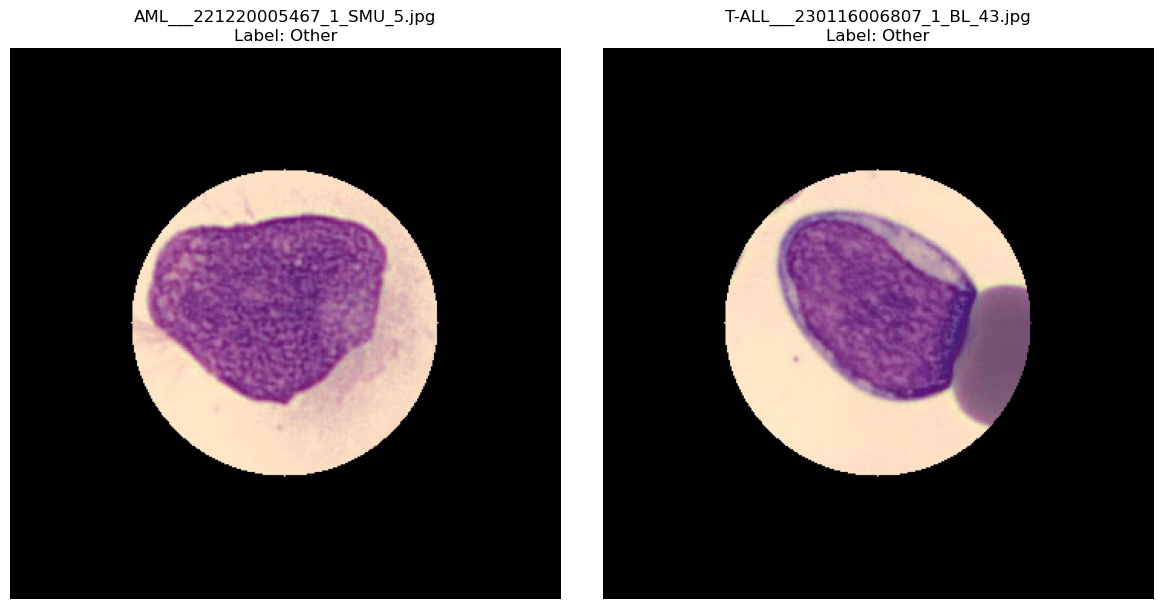


Pair 2: Distance = 0.000070


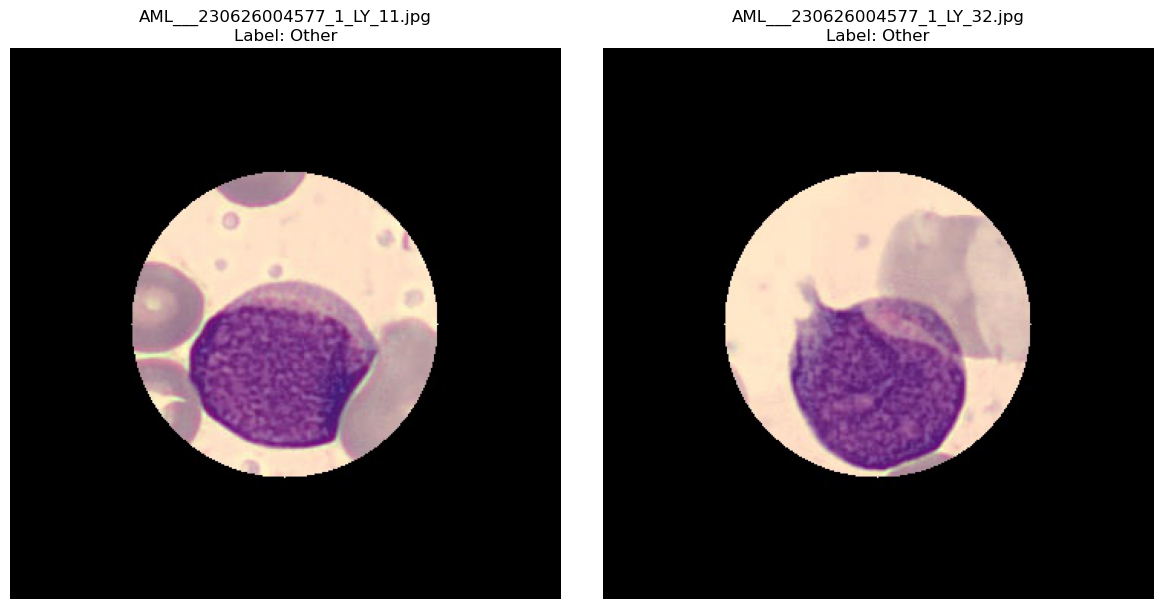


Pair 3: Distance = 0.000074


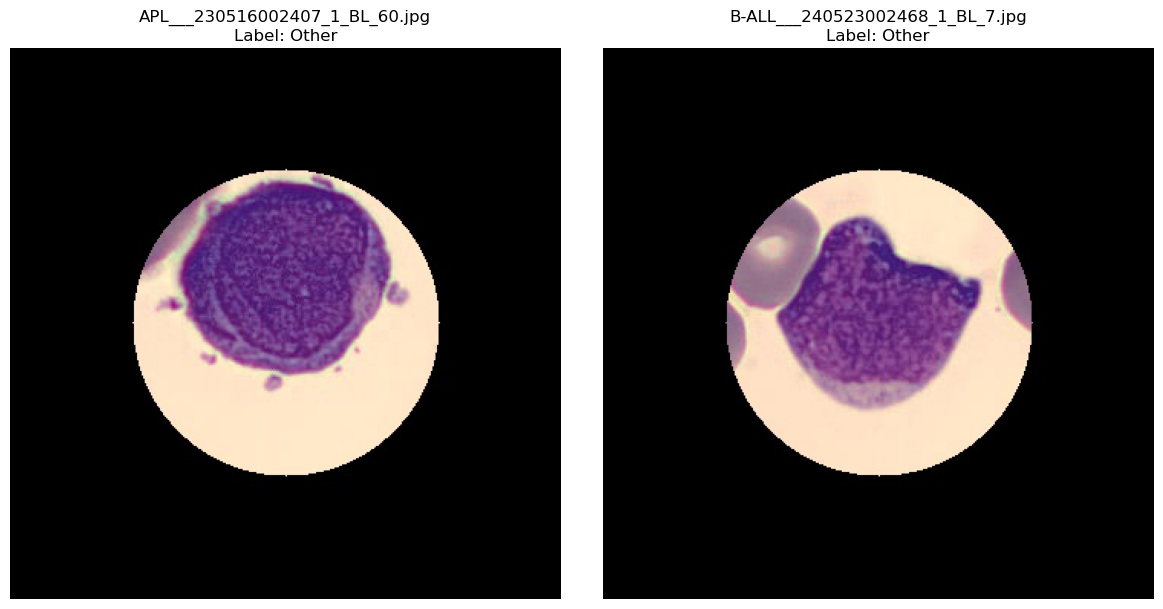

In [19]:
# Visualize the top 25 closest pairs
top_pairs = get_top_x_nearest_pairs(distances_inc, indices_inc, X=3)

for i, (idx1, idx2, dist) in enumerate(top_pairs):
    print(f"\nPair {i+1}: Distance = {dist:.6f}")
    show_duplicate_pair(image_paths_inc, labels_inc, idx1, idx2)


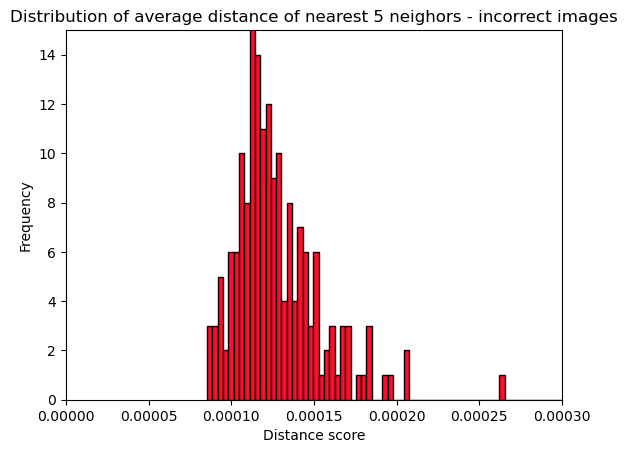

In [16]:
distances_avg_inc = []
for dist in distances_inc:
    distances_avg_inc.append(sum(dist)/5)
    
plt.hist(distances_avg_inc, bins=100, color='#FF0D2A', edgecolor='black')
plt.title("Distribution of average distance of nearest 5 neighors - incorrect images")
ax = plt.gca()
ax.set_xlim([0, 0.00030])
ax.set_ylim([0, 15])
plt.xlabel("Distance score")
plt.ylabel("Frequency")
plt.show()

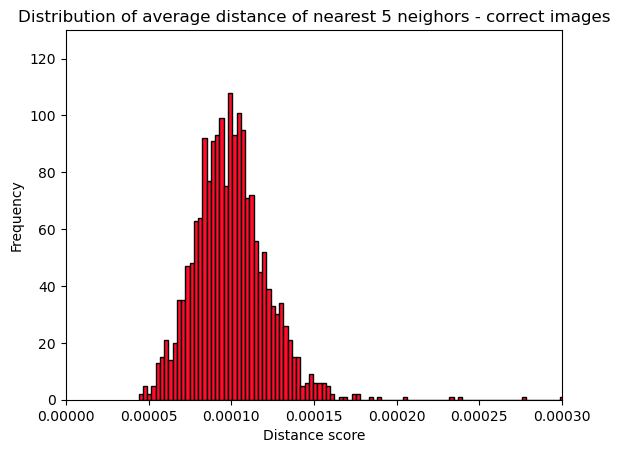

In [17]:
embeddings_cor, labels_cor, image_paths_cor = extract_embeddings(My_model, dataloader, device, correctness=True)
distances_cor, indices_cor = find_nearest_neighbors(embeddings_cor, n_neighbors=5, metric='cosine')

distances_avg_cor = []
for dist in distances_cor:
    #Remove single outlier with average distance of 0.00175
    if (sum(dist/5)) < 0.001:
        distances_avg_cor.append(sum(dist)/5)
    
plt.hist(distances_avg_cor, bins=100, color='#FF0D2A', edgecolor='black')
plt.title("Distribution of average distance of nearest 5 neighors - correct images")
ax = plt.gca()
ax.set_xlim([0, 0.00030])
ax.set_ylim([0, 130])
plt.xlabel("Distance score")
plt.ylabel("Frequency")
plt.show()


Pair 1: Distance = 0.000039


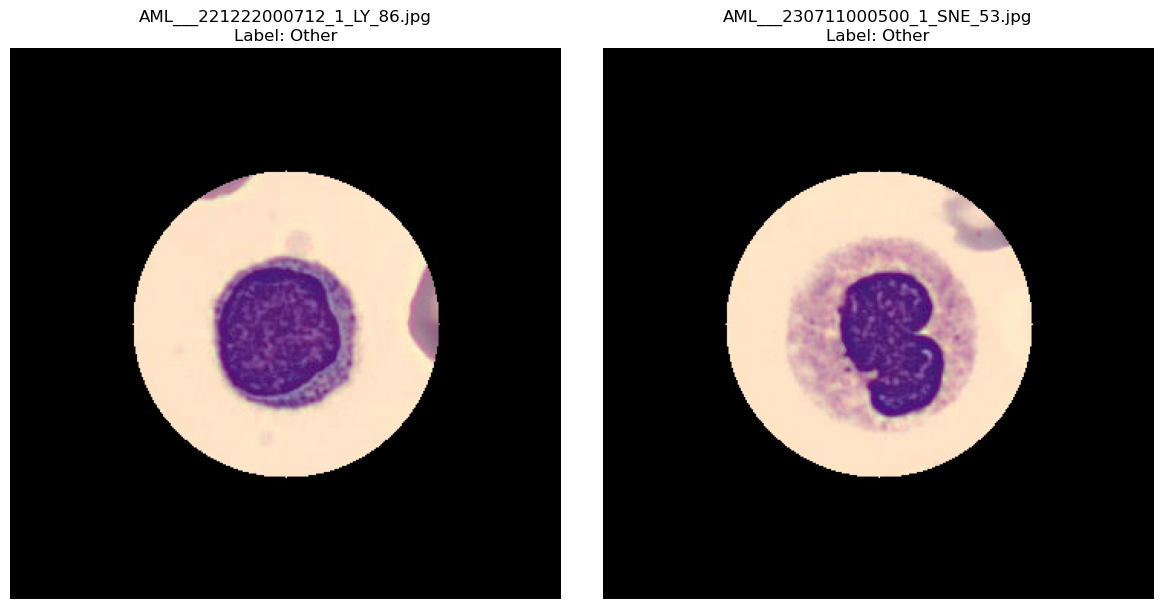


Pair 2: Distance = 0.000039


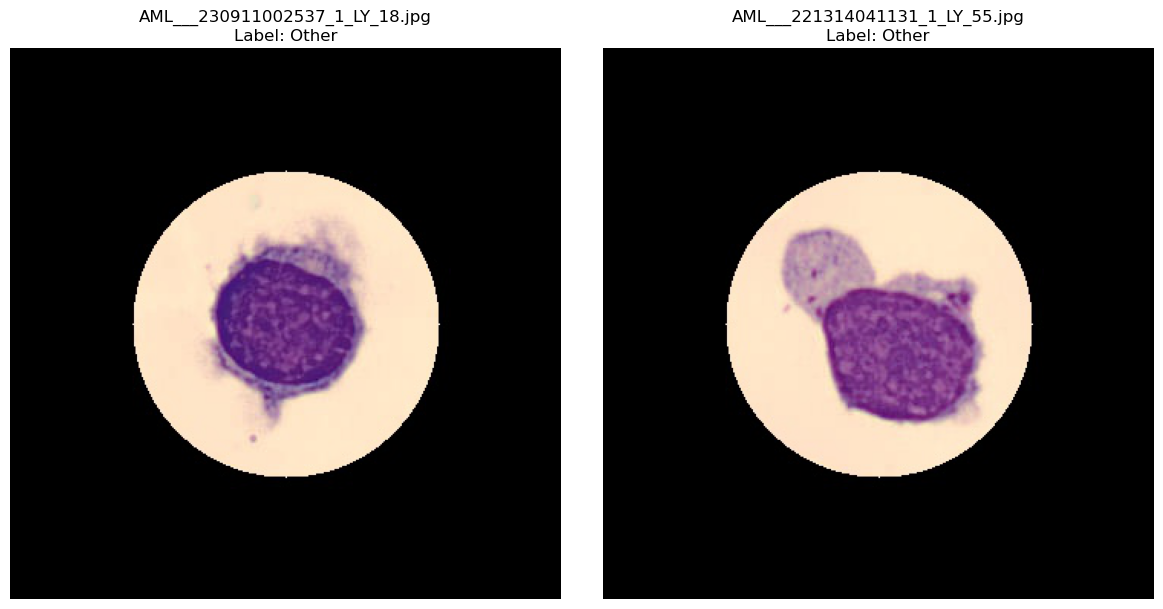


Pair 3: Distance = 0.000039


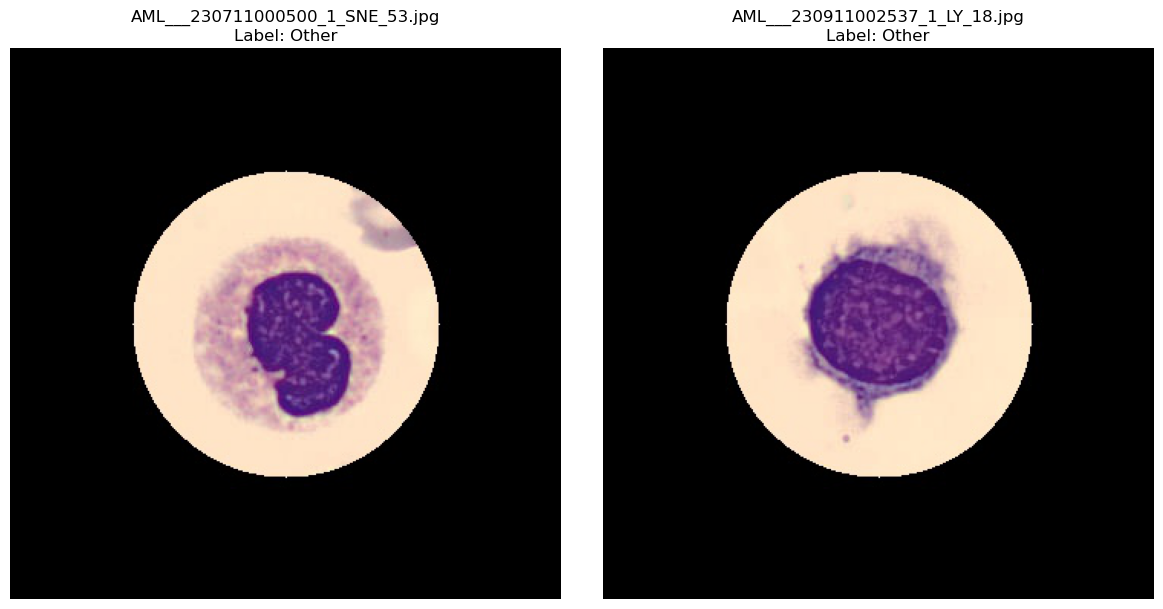

In [22]:
embeddings_cor, labels_cor, image_paths_cor = extract_embeddings(My_model, dataloader, device, correctness=True)
distances_cor, indices_cor = find_nearest_neighbors(embeddings_cor, n_neighbors=5, metric='cosine')

# Visualize the top 25 closest pairs
top_pairs = get_top_x_nearest_pairs(distances_cor, indices_cor, X=6)

for i, (idx1, idx2, dist) in enumerate(top_pairs):
    if (i < 3):
        continue
    print(f"\nPair {i-2}: Distance = {dist:.6f}")
    show_duplicate_pair(image_paths_cor, labels_cor, idx1, idx2)

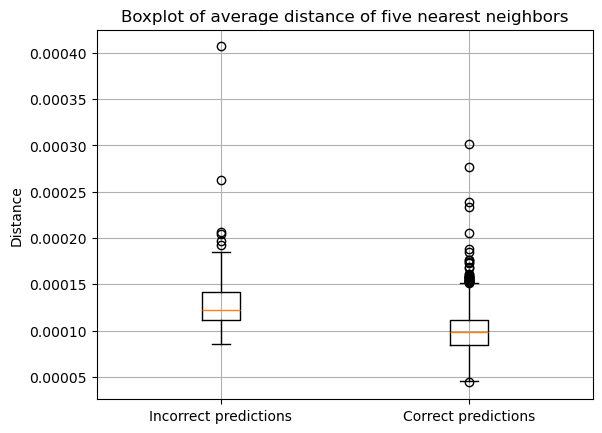

In [18]:
# Combine them into a list of lists for boxplot
data = [distances_avg_inc, distances_avg_cor]

# Create the boxplot
plt.boxplot(data, labels=['Incorrect predictions', 'Correct predictions'])

# Labels and title
plt.ylabel('Distance')
plt.title('Boxplot of average distance of five nearest neighbors')
plt.grid(True)
plt.show()

# Remove all found duplicates

In [80]:
# Removes images from a dataframe
def remove_images_df(df,  duplicates):

    df.reset_index(drop=True)
    filepaths = df['Filepath'].tolist()
    indices = []
    for i in range(len(duplicates)):
        for j in range(len(filepaths)):
            if duplicates[i].split('\\')[-1] == filepaths[j].split('\\')[-1]:
                indices.append(j)
    df = df.drop(indices).reset_index(drop=True)
    return df 

# Removes images from a directory
def remove_images_directory(directory, duplicates):
    
    for filename in duplicates:
        file_path = os.path.join(directory, filename.split('\\')[-1])
        try:
            os.remove(file_path)
        except FileNotFoundError:
            print(f"File not found: {file_path}")
        except Exception as e:
            print(f"Error deleting {file_path}: {e}")

In [84]:
# Images with whom there is a euclidian distance of 0.0 between e.g. X_train and X_test. Hardcoded as running the code above takes >2 hours
duplicatestraintest = ['D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___ERR20250210101550_1_BL_127.jpg', 'D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___221207005714_1_BL_176.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___220712002361_1_BL_167.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___ERR20250210101550_1_BL_141.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___ERR20250210101029_1_BL_142.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___211302811131_1_BL_31.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___220712002361_1_BL_143.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___ERR20250210101550_1_BL_135.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___230626004577_1_BL_174.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___221003005096_1_BL_116.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___221003005096_1_BL_115.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___220712002361_1_BL_161.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___230307000606_1_BL_113.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___ERR20250210101550_1_BL_137.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___230626004577_1_BL_153.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___240524000463_1_BL_150.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___ERR20250210101550_1_BL_129.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___220712002361_1_BL_144.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___220712002361_1_BL_144.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___ERR20250210101550_1_BL_121.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___220712002361_1_BL_123.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___220712002361_1_BL_125.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___240523004481_1_BL_155.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___220712002361_1_BL_154.jpg']
duplicatesvaltest = ['D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___240523004481_1_BL_156.jpg', 'D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___ERR20250210101550_1_BL_124.jpg']
duplicatestrainval = ['D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___220712002361_1_BL_131.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___220712002361_1_PMY_24.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___ERR20250210101550_1_BL_130.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___220712002361_1_BL_117.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___220712002361_1_PMY_22.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___240523004481_1_BL_158.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___230626004577_1_BL_154.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___220712002361_1_BL_128.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___ERR20250210101550_1_BL_118.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___220712002361_1_BL_121.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___220607003832_1_BL_156.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___220712002361_1_BL_178.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___240523004481_1_BL_159.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___220712002361_1_PMY_23.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___221005002617_1_BL_145.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___220712002361_1_BL_163.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___220712002361_1_BL_176.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___220607003832_1_BL_155.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___230626004577_1_BL_168.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___230626004577_1_BL_163.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___230626004577_1_BL_156.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___230626004577_1_BL_147.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___220712002361_1_BL_130.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___220712002361_1_BL_126.jpg','D:\Mathijs\Open Universiteit\Thesis\Implementation\DeepHeme_training\Datasets\notextimages\AML___240523004481_1_BL_155.jpg']

duplicatesall = list(set(duplicatestraintest + duplicatesvaltest + duplicatestrainval)) # 49 duplicates removed using EUCD = 0.0

# Images found using EUCD greater than 0.0 but smaller than 1.0
with open("duplicatesEUCD1.pkl", "rb") as f:
    duplicatesEUCD1 = pickle.load(f)

# Images found with a nearest neighbor algorithm applied to the final layer of the pretrained model with threshold 0.000049
with open("duplicatesNN.pkl", "rb") as f:
    duplicatesNN = pickle.load(f)
    
# Load the dataframes
df = pd.read_pickle('imagepathspriortoEUCD.pkl')
df1 = pd.read_pickle('segmentedimagepathspriortoEUCD.pkl')
df2 = pd.read_pickle('notextimagepathspriortoEUCD.pkl')
df3 = pd.read_pickle('croppedimagepathspriortoEUCD.pkl')

# Print stats prior to removing duplicates with EUCD = 0.0
print(f"lengths prior to removing duplicates:\n imagepaths.pkl shape: {df.shape}\n segmentedimagepaths.pkl shape: {df1.shape}\n notextimagepaths.pkl shape: {df2.shape}\n croppedimagepaths.pkl shape: {df3.shape}")

# Remove the duplicates found using EUCD = 0.0 from the dataframes
df = remove_images_df(df, duplicatesall)
df1 = remove_images_df(df1, duplicatesall)
df2 = remove_images_df(df2, duplicatesall)
df3 = remove_images_df(df3, duplicatesall)

# Print stats after removing duplicates
print(f"lengths after removing duplicates found using EUCD = 0.0:\n imagepaths.pkl shape: {df.shape}\n segmentedimagepaths.pkl shape: {df1.shape}\n notextimagepaths.pkl shape: {df2.shape}\n croppedimagepaths.pkl shape: {df3.shape}")

# Remove the duplicates found using EUCD > 0.0 and < 1.0 from the dataframes
df = remove_images_df(df, duplicatesEUCD1)
df1 = remove_images_df(df1, duplicatesEUCD1)
df2 = remove_images_df(df2, duplicatesEUCD1)
df3 = remove_images_df(df3, duplicatesEUCD1)

# Print stats after removing duplicates
print(f"lengths after removing duplicates found using EUCD = 0.0:\n imagepaths.pkl shape: {df.shape}\n segmentedimagepaths.pkl shape: {df1.shape}\n notextimagepaths.pkl shape: {df2.shape}\n croppedimagepaths.pkl shape: {df3.shape}")

# Remove the duplicates found using EUCD > 0.0 and < 1.0 from the dataframes
df = remove_images_df(df, duplicatesNN)
df1 = remove_images_df(df1, duplicatesNN)
df2 = remove_images_df(df2, duplicatesNN)
df3 = remove_images_df(df3, duplicatesNN)

# Print stats after removing duplicates
print(f"lengths after removing duplicates found using nearest neighbor applied to the final layer = 0.0:\n imagepaths.pkl shape: {df.shape}\n segmentedimagepaths.pkl shape: {df1.shape}\n notextimagepaths.pkl shape: {df2.shape}\n croppedimagepaths.pkl shape: {df3.shape}")

# Update the pickle (.pkl) files
df.to_pickle('imagepaths.pkl')
df1.to_pickle('segmentedimagepaths.pkl')
df2.to_pickle('notextimagepaths.pkl')
df3.to_pickle('croppedimagepaths.pkl')

lengths prior to removing duplicates:
 imagepaths.pkl shape: (20788, 4)
 segmentedimagepaths.pkl shape: (20788, 4)
 notextimagepaths.pkl shape: (20788, 4)
 croppedimagepaths.pkl shape: (20788, 4)
lengths after removing duplicates found using EUCD = 0.0:
 imagepaths.pkl shape: (20739, 4)
 segmentedimagepaths.pkl shape: (20739, 4)
 notextimagepaths.pkl shape: (20739, 4)
 croppedimagepaths.pkl shape: (20739, 4)
lengths after removing duplicates found using EUCD = 0.0:
 imagepaths.pkl shape: (20621, 4)
 segmentedimagepaths.pkl shape: (20621, 4)
 notextimagepaths.pkl shape: (20621, 4)
 croppedimagepaths.pkl shape: (20621, 4)
lengths after removing duplicates found using nearest neighbor applied to the final layer = 0.0:
 imagepaths.pkl shape: (20594, 4)
 segmentedimagepaths.pkl shape: (20594, 4)
 notextimagepaths.pkl shape: (20594, 4)
 croppedimagepaths.pkl shape: (20594, 4)


In [109]:
# # Also delete the images from the directories that correspond to the dataframes above, uncomment if you need to delete again
segimagepaths_dir = 'D:\\Mathijs\\Open Universiteit\\Thesis\\Implementation\\DeepHeme_training\\Datasets\\segmentedimages\\'
notextimagepaths_dir = 'D:\\Mathijs\\Open Universiteit\\Thesis\\Implementation\\DeepHeme_training\\Datasets\\notextimages\\'
croppedimagepaths_dir = 'D:\\Mathijs\\Open Universiteit\\Thesis\\Implementation\\DeepHeme_training\\Datasets\\croppedimages\\'

remove_images_directory(segimagepaths_dir, duplicatesNN)
remove_images_directory(notextimagepaths_dir, duplicatesNN)
remove_images_directory(croppedimagepaths_dir, duplicatesNN)

In [82]:
# Create equivalent dataframe, except the filepaths point at the masked images
df = pd.read_pickle('imagepathspriortoEUCD.pkl')
filepaths = df['Filepath'].tolist()

seg_filepaths = []
seg_dir = 'D:\\Mathijs\\Open Universiteit\\Thesis\\Implementation\\DeepHeme_training\\Datasets\\croppedimages\\'

filepaths[0].split("\\")[-1]
for i, filepath in enumerate(filepaths):
    filename = str(filepaths[i].split("\\")[-1])
    seg_img_path = seg_dir + filename
    seg_filepaths.append(seg_img_path)

seg_df = df.copy()
seg_df['Filepath'] = seg_filepaths
seg_df.to_pickle('croppedimagepathspriortoEUCD.pkl')
seg_df.head()

,Filepath,Label,Final diagnosis,Classnames
0,D:\Mathijs\Open Universiteit\Thesis\Implementa...,Other,AML,SMU
1,D:\Mathijs\Open Universiteit\Thesis\Implementa...,Lymphoid,B-ALL,BL
2,D:\Mathijs\Open Universiteit\Thesis\Implementa...,Other,AML,SNE
3,D:\Mathijs\Open Universiteit\Thesis\Implementa...,Other,AML,SNE
4,D:\Mathijs\Open Universiteit\Thesis\Implementa...,Myeloid,AML,BL


# Derive weights for weighted loss function

In [49]:
# Calculate weights based on respective class counts
label_counts = list(Counter(df['Label']).values())  # Count per class
total = sum(label_counts)
class_weights = [total / label_counts[c] for c in range(3)]

#Normalize weights
class_weights = torch.tensor(class_weights, dtype=torch.float)
class_weights = class_weights / class_weights.sum()

# 0.0804 for 'Other', 0.7941 for 'Lymphoid',  and 0.1255 for 'Myeloid'
class_weights

tensor([0.0804, 0.7941, 0.1255])

In [50]:
label_counts

[11821, 1197, 7576]

# Count images sizes

In [5]:
df = pd.read_pickle('imagepaths.pkl')
df.head()
filepathsother = df[df['Label']=='Other']['Filepath'].tolist()
filepathslymphoid = df[df['Label']=='Lymphoid']['Filepath'].tolist()
filepathsmyeloid = df[df['Label']=='Myeloid']['Filepath'].tolist()

In [4]:
from PIL import Image
from collections import Counter



def count_sizes(filepaths):

    # Counter to store dimension counts
    dimension_counts = Counter()
    
    for path in filepaths:
        try:
            with Image.open(path) as img:
                width, height = img.size
                dimension_counts[(width, height)] += 1
        except Exception as e:
            print(f"Error loading {path}: {e}")
    return dimension_counts

othercounts = count_sizes(filepathsother)
lymphoidcounts = count_sizes(filepathslymphoid)
myeloidcounts = count_sizes(filepathsmyeloid)

In [12]:
#Summary of combined results: 20479 images have 360x360 res, 97 images have one of 48 different resolutions

# Print the results

# Number of dimensions, - 2 because of double 360x360
dimcount = len(lymphoidcounts) + len(myeloidcounts) + len(othercounts) - 2 
print(f"Number of unique resolutions: {dimcount}")
for dim, count in lymphoidcounts.items():
    print(f"Lymphoid Dimensions {dim}: {count} image(s)\n\n")

for dim, count in myeloidcounts.items():
    print(f"Myeloid Dimensions {dim}: {count} image(s)\n\n")

for dim, count in othercounts.items():
    print(f"Other Dimensions {dim}: {count} image(s)\n\n")



Number of unique resolutions: 49
Lymphoid Dimensions (360, 360): 1197 image(s)


Myeloid Dimensions (360, 360): 7568 image(s)


Myeloid Dimensions (360, 384): 2 image(s)


Myeloid Dimensions (400, 392): 1 image(s)


Myeloid Dimensions (440, 392): 1 image(s)


Myeloid Dimensions (360, 376): 1 image(s)


Myeloid Dimensions (360, 368): 1 image(s)


Myeloid Dimensions (424, 360): 1 image(s)


Myeloid Dimensions (400, 360): 1 image(s)


Other Dimensions (360, 360): 11732 image(s)


Other Dimensions (2864, 2868): 5 image(s)


Other Dimensions (2864, 2872): 2 image(s)


Other Dimensions (360, 408): 1 image(s)


Other Dimensions (2864, 2875): 1 image(s)


Other Dimensions (360, 432): 1 image(s)


Other Dimensions (2864, 2871): 7 image(s)


Other Dimensions (2864, 2862): 1 image(s)


Other Dimensions (2864, 2874): 2 image(s)


Other Dimensions (2864, 2877): 3 image(s)


Other Dimensions (2864, 2873): 6 image(s)


Other Dimensions (2872, 2873): 1 image(s)


Other Dimensions (2864, 2860): 1 image

# For each image in the testset, add several rotated images and see whether results are the same for each rotation

In [2]:
# Load the data, split it into training and validation dataframes
df = pd.read_pickle('notextimagepaths.pkl')

train_df, val_df = train_test_split(df, test_size=0.20, random_state=42, stratify=df['Label'])
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42, stratify=val_df['Label'])

# Load filepaths, random state ensures testset is the same as in Training.ipynb
X_all = df['Filepath'].to_list()
X_train = train_df['Filepath'].to_list()
X_val = val_df['Filepath'].to_list()
X_test = test_df['Filepath'].to_list()

# Load labels
all_labels = df['Label'].to_list()
train_labels = train_df['Label'].to_list()
validation_labels = val_df['Label'].to_list()
test_labels = test_df['Label'].to_list()

# Load df that represents the one hot encoding of each cell type (Myeloid, Lymphoid, other)
cell_types_df = pd.read_pickle("cell_types_df.pkl")

In [6]:
# Define the output directory
output_dir = 'D:\\Mathijs\\Open Universiteit\\Thesis\\Implementation\\DeepHeme_training\\Datasets\\notextrotatedimagesexperiment'
os.makedirs(output_dir, exist_ok=True)

# Data to build the DataFrame
filepaths = []
original_indices = []
labels = []

# Loop over each image and apply 24 rotations
for idx, (filepath, label) in tqdm(enumerate(zip(X_test, test_labels)), total=len(X_test)):
    # Read the image
    image = cv2.imread(filepath)
    if image is None:
        print(f"Warning: Unable to read image at {filepath}")
        continue

    h, w = image.shape[:2]
    center = (w // 2, h // 2)

    for angle in range(0, 360, 15):
        # Rotation matrix and applying it
        rot_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated_image = cv2.warpAffine(image, rot_matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)

        # Generate output filename
        original_filename = os.path.basename(filepath)
        name, ext = os.path.splitext(original_filename)
        new_filename = f"{name}_{angle}{ext}"
        new_filepath = os.path.join(output_dir, new_filename)

        # Save the rotated image
        cv2.imwrite(new_filepath, rotated_image)

        # Append info to dataframe lists
        filepaths.append(new_filepath)
        original_indices.append(idx)
        labels.append(label)

# Create DataFrame
df_rot = pd.DataFrame({
    'Filepath': filepaths,
    'Original index': original_indices,
    'Label': labels
})

#Save to pickle
df_rot.to_pickle('notextrotatedimagepaths.pkl')
_df = pd.read_pickle('notextrotatedimagepaths.pkl')
_df.head(3)

100%|██████████████████████████████████████████████████████████████████████████████| 2060/2060 [09:02<00:00,  3.80it/s]


,Filepath,Original index,Label
0,D:\Mathijs\Open Universiteit\Thesis\Implementa...,0,Myeloid
1,D:\Mathijs\Open Universiteit\Thesis\Implementa...,0,Myeloid
2,D:\Mathijs\Open Universiteit\Thesis\Implementa...,0,Myeloid


In [43]:
temp = pd.read_pickle('rotatedimagepaths.pkl')

In [44]:
temp

,Filepath,Original index,Label
0,D:\Mathijs\Open Universiteit\Thesis\Implementa...,0,Myeloid
1,D:\Mathijs\Open Universiteit\Thesis\Implementa...,0,Myeloid
2,D:\Mathijs\Open Universiteit\Thesis\Implementa...,0,Myeloid
3,D:\Mathijs\Open Universiteit\Thesis\Implementa...,0,Myeloid
4,D:\Mathijs\Open Universiteit\Thesis\Implementa...,0,Myeloid
...,...,...,...
49435,D:\Mathijs\Open Universiteit\Thesis\Implementa...,2059,Other
49436,D:\Mathijs\Open Universiteit\Thesis\Implementa...,2059,Other
49437,D:\Mathijs\Open Universiteit\Thesis\Implementa...,2059,Other
49438,D:\Mathijs\Open Universiteit\Thesis\Implementa...,2059,Other
